# Kidney Stone Detection in Ultrasound and/or CT Scan Images Using Deep Learning.

###Step 1. Connect to your drive (Mount Drive)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Step 2. Import all the library

In [3]:
import numpy as np
import pandas as pd
import cv2
from sklearn.utils.multiclass import unique_labels
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
from keras.models import load_model
from keras.applications.vgg16 import VGG16 #For Transfer Learning
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from tensorflow.keras.utils import to_categorical

###Step 3. Install split_folders

In [4]:
!pip install split_folders

###Step 4. Provide path of the dataset and split the dataset

In [7]:
import splitfolders
splitfolders.ratio("/content/drive/MyDrive/Colab Notebooks/MiniProjects/KidneyDisease_Dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone", output="dataset", seed=1337, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 12446 files [08:04, 25.68 files/s]


In [8]:
channels=3
batch_size=25
test_batch_size=32
test_steps=1
train_path = './dataset/train'
test_path = './dataset/test'
val_path = './dataset/val'

def scalar(img):
    return img  # EfficientNet expects pixelsin range 0 to 255 so no scaling is required

train_gen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
test_gen=ImageDataGenerator(preprocessing_function=scalar)
train_generator=train_gen.flow_from_directory( directory=train_path , target_size=(224,224), class_mode='categorical',
                                     shuffle=True, batch_size=batch_size)
test_generator=test_gen.flow_from_directory( directory=test_path, target_size=(224,224), class_mode='categorical',
                                     shuffle=False, batch_size=test_batch_size)

valid_generator=test_gen.flow_from_directory( directory=val_path, target_size=(224,224), class_mode='categorical',
                                     shuffle=True, batch_size=batch_size)
classes=list(train_generator.class_indices.keys())
class_count=len(classes)
train_steps=int(np.ceil(len(train_generator.labels)/batch_size))

Found 9955 images belonging to 4 classes.
Found 1249 images belonging to 4 classes.
Found 1242 images belonging to 4 classes.


In [9]:
base_model = VGG16(include_top = False, input_shape = (224,224,3), classes = 38)
model= Sequential()
model.add(base_model)
model.add(Flatten())

58889256/58889256 [==============================] - 0s 0us/step


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
Total params: 14714688 (56.13 MB)
Trainable params: 14714688 (56.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
model.add(Dense(1024,activation=('relu'),input_dim=512))
model.add(Dense(512,activation=('relu')))
model.add(Dense(256,activation=('relu')))
model.add(Dropout(.3))
model.add(Dense(128,activation=('relu')))
model.add(Dense(4,activation=('softmax')))

#Checking the final model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               3

In [12]:
from keras.optimizers import SGD, Adam
batch_size= 1218
epochs=15
learn_rate=.001
sgd = SGD(learning_rate=learn_rate, momentum=0.9, nesterov=False)
adam = Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
history = model.fit(train_generator,epochs = 10, validation_data = valid_generator, verbose = 1)

Epoch 1/10
399/399 [==============================] - 179s 384ms/step - loss: 1.3861 - accuracy: 0.4220 - val_loss: 1.1028 - val_accuracy: 0.5499
Epoch 2/10
399/399 [==============================] - 148s 371ms/step - loss: 1.1371 - accuracy: 0.5165 - val_loss: 1.0412 - val_accuracy: 0.5580
Epoch 3/10
399/399 [==============================] - 148s 369ms/step - loss: 0.7969 - accuracy: 0.6839 - val_loss: 0.4914 - val_accuracy: 0.8052
Epoch 4/10
399/399 [==============================] - 148s 371ms/step - loss: 0.4408 - accuracy: 0.8353 - val_loss: 0.4396 - val_accuracy: 0.8446
Epoch 5/10
399/399 [==============================] - 148s 370ms/step - loss: 0.2694 - accuracy: 0.8993 - val_loss: 0.2278 - val_accuracy: 0.9098
Epoch 6/10
399/399 [==============================] - 149s 372ms/step - loss: 0.1749 - accuracy: 0.9387 - val_loss: 0.0974 - val_accuracy: 0.9702
Epoch 7/10
399/399 [==============================] - 148s 371ms/step - loss: 0.0964 - accuracy: 0.9678 - val_loss: 0.1104 -

In [14]:
def print_info( test_gen, preds, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    errors=0
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors=errors + 1
        y_pred.append(pred_index)
#     if errors>0:
#         plot_bar=[]
#         plot_class=[]
#         for  key, value in new_dict.items():
#             count=error_indices.count(key)
#             if count!=0:
#                 plot_bar.append(count) # list containg how many times a class c had an error
#                 plot_class.append(value)   # stores the class
#         fig=plt.figure()
#         fig.set_figheight(len(plot_class)/3)
#         fig.set_figwidth(10)
#         plt.style.use('fivethirtyeight')
#         for i in range(0, len(plot_class)):
#             c=plot_class[i]
#             x=plot_bar[i]
#             plt.barh(c, x, )
#             plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)
    y_pred=np.array(y_pred)
    if len(classes)<= 40:
        # create a confusion matrix
        cm = confusion_matrix(y_true, y_pred )
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

###Step 5. Confusion matrix

40/40 [==============================] - 17s 246ms/step


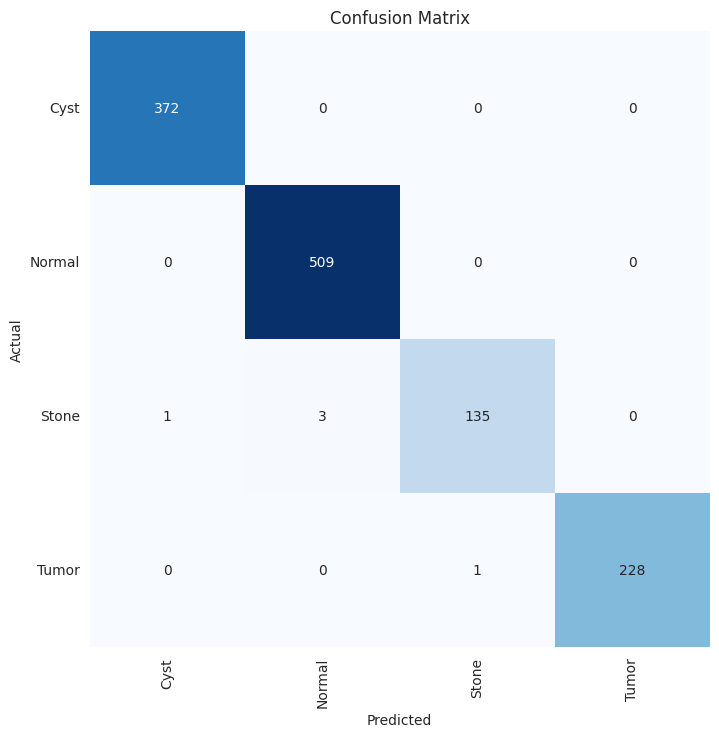

Classification Report:
----------------------
               precision    recall  f1-score   support

        Cyst       1.00      1.00      1.00       372
      Normal       0.99      1.00      1.00       509
       Stone       0.99      0.97      0.98       139
       Tumor       1.00      1.00      1.00       229

    accuracy                           1.00      1249
   macro avg       1.00      0.99      0.99      1249
weighted avg       1.00      1.00      1.00      1249



In [15]:
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
p = model.predict(test_generator)
print_info( test_generator, p, r'./', 'kidney')

###Step 6. Model Accuracy

In [16]:
model.evaluate(test_generator)

40/40 [==============================] - 10s 234ms/step - loss: 0.0273 - accuracy: 0.9960


[0.02733251452445984, 0.9959967732429504]

###Step 7. Save the model name "vgg16.h5"
(model can be saved in the same directory where this file will be executed)

In [17]:
model.save("vgg16.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
history.params
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']

###Step 8. Training and Validation Accuracy

Text(0.5, 1.0, 'Training and Validation Accuracy')

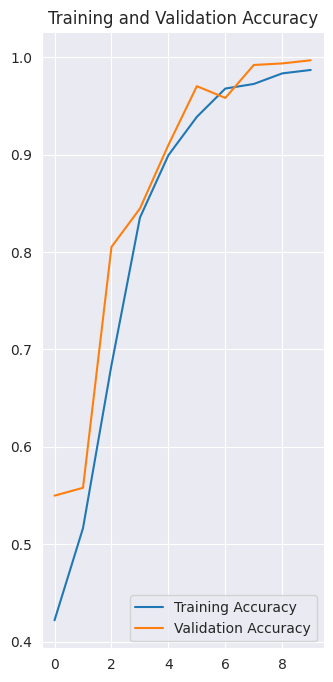

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(10), acc, label='Training Accuracy')
plt.plot(range(10), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

###Step 9. Training and Validation Loss

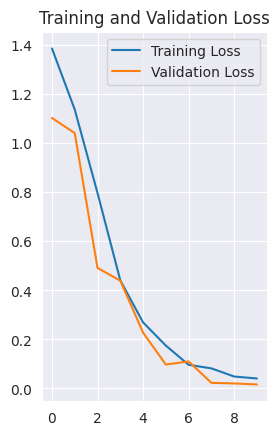

In [23]:
plt.subplot(1, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Step 10. Function to plot the trained image
(which can be generated after training the model in you directory name "dataset")

In [26]:
def plot_imgs(item_dir, num_imgs=25):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_imgs]

    plt.figure(figsize=(10, 10))
    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)
        img = plt.imread(img_path)
        plt.title(f'{img_path}'[-10:-4])
        plt.imshow(img)

    plt.tight_layout()

###Step 11. Provide the path of the trained dataset
(which is path_normal contain in this "dataset/train/Normal" and path_stone contain in this "dataset/train/Normal"

In [27]:
path_normal = '/content/drive/MyDrive/Colab Notebooks/MiniProjects/dataset/train/Normal'
path_stone = '/content/drive/MyDrive/Colab Notebooks/MiniProjects/dataset/train/Stone'

###Trained Stone Images

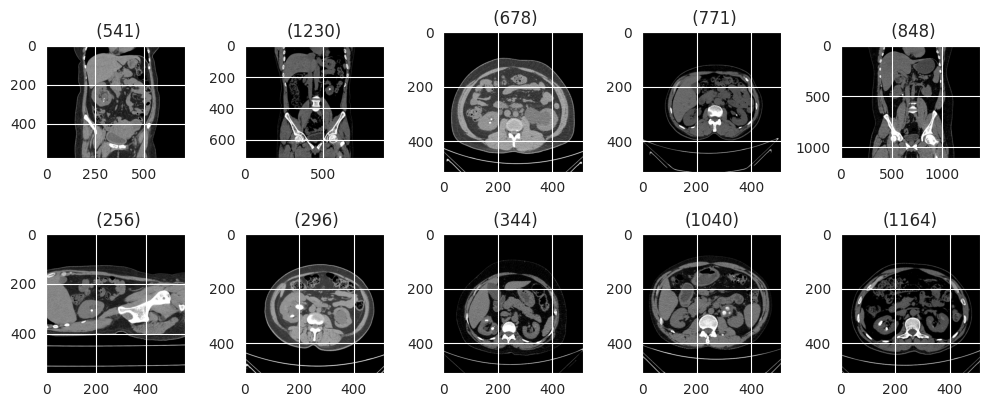

In [28]:
plot_imgs(path_stone, 10)

###Normal Images

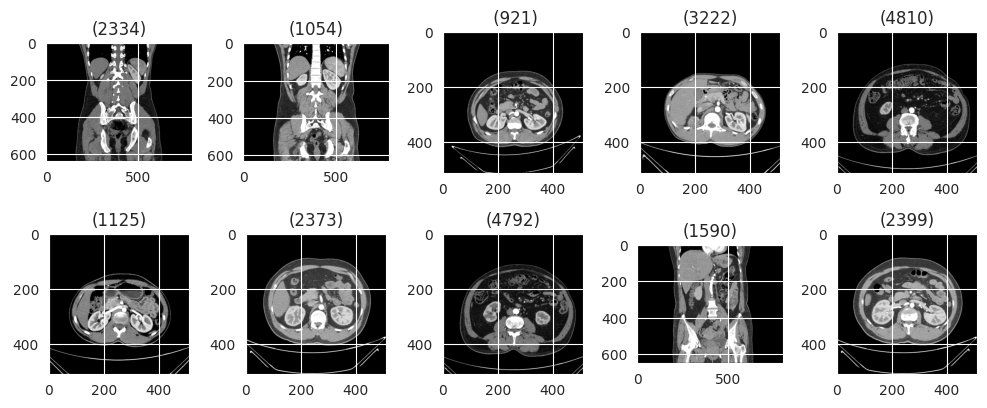

In [29]:
plot_imgs(path_normal, 10)